In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nashpy as nash
import itertools
import cvxpy as cp
import cvxopt
from tqdm import tqdm
import seaborn as sb
from scipy.stats import skewnorm
from scipy.optimize import minimize
import pickle

In [16]:
def win_rate_elo(elo1, elo2, alpha = np.log(10)/400):
    """
    Computes win rate of player 1 to player 2 given their elo ratings
    """
    return 1 / (1 + np.exp(-alpha * (elo1 - elo2)))

def create_bins(lower_bound, upper_bound, n):
    width = (upper_bound - lower_bound) / n
    
    ub = lower_bound + width; lb = lower_bound; bins = [(lb, ub)]
    for _ in range(n-1):
        lb += width; ub += width; bins.append((lb, ub))
    
    return bins

def within(bin_range, num):
    return num >= bin_range[0] and num < bin_range[1]

In [24]:
# Functions
def create_payoff(n, bin_lb, bin_ub):
    # Construct payoff template and bins
    # Also returns marker array, to indicate whether one missing, both missing, or none missing
    bins = np.array(create_bins(bin_lb, bin_ub, n))
    payoff = np.ones((n, n)) * -8; np.fill_diagonal(payoff, 0)
    
    # Marker matrix to indicate missing data. 1 for both present, -1 for p1 white, -2 for p1 black, -3 for both series
    mat = np.zeros((n, n))
    
    for i in tqdm(range(len(bins))):
        for j in range(len(bins)):
           # These are actually p1 and p2 ratings. We want to find where this p1 rating is white vs p2 black and
            # then vice versa
            p1_bin_lb, p1_bin_ub = bins[i]
            p2_bin_lb, p2_bin_ub = bins[j] 
            
            # Mid-bin rating to predict if missing
            p1_rating = (p1_bin_ub + p1_bin_lb) / 2
            p2_rating = (p2_bin_ub + p2_bin_lb) / 2
            
            if p1_bin_lb >= p2_bin_lb:
                continue
            else:
                # Sieve off data
                p1_white = (df['white_elo'] < p1_bin_ub) & (df['white_elo'] >= p1_bin_lb)
                p2_white = (df['white_elo'] < p2_bin_ub) & (df['white_elo'] >= p2_bin_lb)

                p1_black = (df['black_elo'] < p1_bin_ub) & (df['black_elo'] >= p1_bin_lb)
                p2_black = (df['black_elo'] < p2_bin_ub) & (df['black_elo'] >= p2_bin_lb)

                # Count data available
                p1_white_counts = np.sum(p1_white); p1_black_counts = np.sum(p1_black)
                p2_white_counts = np.sum(p2_white); p2_black_counts = np.sum(p2_black)

                # bool_ser1 = p1 white and p2 black; bool_ser2 = p1 black and p2 white
                bool_ser1 = p1_white & p2_black; bool_ser2 = p1_black & p2_white
                ser1_count = np.sum(bool_ser1); ser2_count = np.sum(bool_ser2)

                if ser1_count != 0 and ser2_count != 0:
                    # Both matchups exist in data
                    # To get average, must put a - b, since if black wins, result is -1. Payoff matrix
                    # is wrt to player 1
                    value = (np.mean(df[bool_ser1]['result']) - np.mean(df[bool_ser2]['result'])) / 2
                    payoff[i,j] = value
                    payoff[j,i] = -value
                    mat[i,j] = 1; mat[j,i] = 1
                else:
                    if ser1_count !=0 and ser2_count == 0:
                        # i.e. series 2 matchup don't exist. Hence series 1 use real data
#                         print(f"P1 rating {(p1_bin_lb, p1_bin_ub)}, P2 rating {(p2_bin_lb, p2_bin_ub)}, series 2 missing")
                        ser1_rate = np.mean(df[bool_ser1]['result'])

                        # Predict series 2 with elo. This don't care who is white/black
                        # NOTE: win probability is probability of player 1 winning, yielding a reward of +1
                        # To find expected score, must multiply probability with score
                        win_prob = win_rate_elo(p1_rating, p2_rating)
                        ser2_rate = win_prob * 1 + (1 - win_prob) * -1
                
                        value = (ser1_rate + ser2_rate) / 2
                        payoff[i,j] = value
                        payoff[j,i] = -value
                        mat[i,j] = -2
                        mat[j,i] = -2

                    if ser1_count == 0 and ser2_count != 0:
                        # i.e. series 1 matchup don't exist. Hence series 2 use real data
#                         print(f"P1 rating {(p1_bin_lb, p1_bin_ub)}, P2 rating {(p2_bin_lb, p2_bin_ub)}, series 1 missing")
                        win_prob = win_rate_elo(p1_rating, p2_rating)
                        ser1_rate = win_prob * 1 + (1 - win_prob) * -1
                        ser2_rate = np.mean(df[bool_ser2]['result'])
                        value = (ser1_rate - ser2_rate) / 2
                        payoff[i,j] = value
                        payoff[j,i] = -value
                        mat[i,j] = -1; mat[j,i] = -1

                    if ser1_count == 0 and ser2_count == 0:
#                         print(f"P1 rating {(p1_bin_lb, p1_bin_ub)}, P2 rating {(p2_bin_lb, p2_bin_ub)}, both missing")
                        # i.e. both are missing, predict using elo
                        win_prob = win_rate_elo(p1_rating, p2_rating)
                        value = win_prob * 1 + (1 - win_prob) * (-1)
                        payoff[i,j] = value
                        payoff[j,i] = -value
                        mat[i,j] = -3; mat[j,i] = -3
                        
    return payoff, mat


# def create_payoff_2(white_bins, black_bins):
#     # Construct payoff template and bins
#     # Also returns marker array, to indicate whether one missing, both missing, or none missing
#     n_row = len(white_bins); n_col = len(black_bins)
#     payoff = np.ones((n_row, n_col)) * -8; np.fill_diagonal(payoff, 0)
    
#     # Marker matrix to indicate missing data. 1 for both present, -1 for p1 white, -2 for p1 black, -3 for both series
#     mat = np.zeros((n_row, n_col))
    
#     for i in tqdm(range(n_row)):
#         for j in range(range(n_col)):
#            # These are actually p1 and p2 ratings. We want to find where this p1 rating is white vs p2 black and
#             # then vice versa
#             p1_bin_lb, p1_bin_ub = white_bins[i]
#             p2_bin_lb, p2_bin_ub = black_bins[j]
            
#             # Mid-bin rating to predict if missing
#             p1_rating = (p1_bin_ub + p1_bin_lb) / 2
#             p2_rating = (p2_bin_ub + p2_bin_lb) / 2
            
#             if p1_bin_lb >= p2_bin_lb:
#                 continue
#             else:
#                 # Sieve off data
#                 p1_white = (df['white_elo'] < p1_bin_ub) & (df['white_elo'] >= p1_bin_lb)
#                 p2_white = (df['white_elo'] < p2_bin_ub) & (df['white_elo'] >= p2_bin_lb)

#                 p1_black = (df['black_elo'] < p1_bin_ub) & (df['black_elo'] >= p1_bin_lb)
#                 p2_black = (df['black_elo'] < p2_bin_ub) & (df['black_elo'] >= p2_bin_lb)

#                 # Count data available
#                 p1_white_counts = np.sum(p1_white); p1_black_counts = np.sum(p1_black)
#                 p2_white_counts = np.sum(p2_white); p2_black_counts = np.sum(p2_black)

#                 # bool_ser1 = p1 white and p2 black; bool_ser2 = p1 black and p2 white
#                 bool_ser1 = p1_white & p2_black; bool_ser2 = p1_black & p2_white
#                 ser1_count = np.sum(bool_ser1); ser2_count = np.sum(bool_ser2)

#                 if ser1_count != 0 and ser2_count != 0:
#                     # Both matchups exist in data
#                     # To get average, must put a - b, since if black wins, result is -1. Payoff matrix
#                     # is wrt to player 1
#                     value = (np.mean(df[bool_ser1]['result']) - np.mean(df[bool_ser2]['result'])) / 2
#                     payoff[i,j] = value
#                     payoff[j,i] = -value
#                     mat[i,j] = 1; mat[j,i] = 1
#                 else:
#                     if ser1_count !=0 and ser2_count == 0:
#                         # i.e. series 2 matchup don't exist. Hence series 1 use real data
# #                         print(f"P1 rating {(p1_bin_lb, p1_bin_ub)}, P2 rating {(p2_bin_lb, p2_bin_ub)}, series 2 missing")
#                         ser1_rate = np.mean(df[bool_ser1]['result'])

#                         # Predict series 2 with elo. This don't care who is white/black
#                         # NOTE: win probability is probability of player 1 winning, yielding a reward of +1
#                         # To find expected score, must multiply probability with score
#                         win_prob = win_rate_elo(p1_rating, p2_rating)
#                         ser2_rate = win_prob * 1 + (1 - win_prob) * -1
                
#                         value = (ser1_rate + ser2_rate) / 2
#                         payoff[i,j] = value
#                         payoff[j,i] = -value
#                         mat[i,j] = -2
#                         mat[j,i] = -2

#                     if ser1_count == 0 and ser2_count != 0:
#                         # i.e. series 1 matchup don't exist. Hence series 2 use real data
# #                         print(f"P1 rating {(p1_bin_lb, p1_bin_ub)}, P2 rating {(p2_bin_lb, p2_bin_ub)}, series 1 missing")
#                         win_prob = win_rate_elo(p1_rating, p2_rating)
#                         ser1_rate = win_prob * 1 + (1 - win_prob) * -1
#                         ser2_rate = np.mean(df[bool_ser2]['result'])
#                         value = (ser1_rate - ser2_rate) / 2
#                         payoff[i,j] = value
#                         payoff[j,i] = -value
#                         mat[i,j] = -1; mat[j,i] = -1

#                     if ser1_count == 0 and ser2_count == 0:
# #                         print(f"P1 rating {(p1_bin_lb, p1_bin_ub)}, P2 rating {(p2_bin_lb, p2_bin_ub)}, both missing")
#                         # i.e. both are missing, predict using elo
#                         win_prob = win_rate_elo(p1_rating, p2_rating)
#                         value = win_prob * 1 + (1 - win_prob) * (-1)
#                         payoff[i,j] = value
#                         payoff[j,i] = -value
#                         mat[i,j] = -3; mat[j,i] = -3
                        
#     return payoff, mat

def create_payoff_elo(bin_lb, bin_ub, n):
    bins = np.array(create_bins(bin_lb, bin_ub, n))
    payoff = np.ones((n, n)) * -8; np.fill_diagonal(payoff, 0)
    
    for i in tqdm(range(len(bins))):
        for j in range(len(bins)):
            p1_bin_lb, p1_bin_ub = white_bins[i]
            p2_bin_lb, p2_bin_ub = black_bins[j]
            
            # Mid-bin rating to predict if missing
            p1_rating = (p1_bin_ub + p1_bin_lb) / 2
            p2_rating = (p2_bin_ub + p2_bin_lb) / 2
            
            if p1_bin_lb >= p2_bin_lb:
                continue
            else:
                win_prob = win_rate_elo(p1_rating, p2_rating)
                value = win_prob * 1 + (1 - win_prob) * (-1)
                payoff[i,j] = value
                payoff[j,i] = -value
                
    return payoff
                
class NashCluster():
    
    def __init__(self, strat_payoffs, ori_idx, pvect):
        self.size = strat_payoffs.shape[0]
        self.payoffs = strat_payoffs
        self.strat_idx = ori_idx
        self.probability = pvect
        
    def computeRPS(self):
        return None
    
def solve_MaxEnt_NE(payoff, verbose = False, eps = 1e-5, zero_tol = 1e-6, iters = 500, cycle = 5):
    
    init_val = np.random.uniform(size = payoff.shape[0])
    init_val = init_val / np.sum(init_val)
    
    p = cp.Variable(payoff.shape[0], value = init_val)
    constraints = [payoff @ p <= 0, cp.sum(p) == 1, p >= 0]
    objective = cp.sum(cp.entr(p))
    prob = cp.Problem(cp.Maximize(objective), constraints)
    
    try:
      cycle_count = 0; done = False
      while cycle_count < cycle and done is False:
        prob.solve(verbose = verbose, solver = cp.MOSEK, warm_start = True)
        p_vect = p.value * (p.value > zero_tol)
        diff = payoff @ p_vect.reshape(-1, 1)
        print(f"Cycle count {cycle_count}, diff = {np.sum(diff >= eps)}")
        done = True if np.sum(diff >= eps) == 0 else False
        cycle_count += 1
    except cp.SolverError:
      print("MOSEK FAILED?")
      try:
        # Try ECOS_BB first
        cycle_count = 0; done = False
        while cycle_count < cycle and done is False:
          prob.solve(verbose = verbose, max_iters = 1000, solver = cp.ECOS_BB, warm_start = True)
          p_vect = p.value * (p.value > zero_tol)
          diff = payoff @ p_vect.reshape(-1, 1)
          print(f"Cycle count {cycle_count}, diff = {np.sum(diff >= eps)}")
          done = True if np.sum(diff >= eps) == 0 else False
          cycle_count += 1
      except cp.SolverError:
        print("ECOS_BB FAILED")
        cycle_count = 0; done = False
        while cycle_count < cycle and done is False:
          prob.solve(verbose = verbose, max_iters = iters, solver = cp.SCS, warm_start = True)
          p_vect = p.value * (p.value > zero_tol)
          diff = payoff @ p_vect.reshape(-1, 1)
          print(f"Cycle count {cycle_count}, diff = {np.sum(diff >= eps)}")
          done = True if np.sum(diff >= eps) == 0 else False
          cycle_count += 1
  
    # Clean - small values
    p_vect = p_vect * (p_vect > zero_tol)
    return p_vect, np.sum(diff>=eps)
    
def Nash_Clustering(payoff, marker, algo = "cvx", eps = 1e-4, zero_tol = 1e-8):
    n_strat = payoff.shape[0]; counter = 0;

    # This is the remaining payoff and the remaining strategy indexes
    curr_payoff = payoff; curr_remaining = np.arange(n_strat); curr_marker = marker
    nash_clusters = []; unsolved_cases = []; marker_instances = []

    while n_strat > 1: # if only 1 strategy remaining, this itself is the nash cluster
        print(f"Iteration {counter}")

        # # Compute the NE supports. Lemke Howson seems the fastest
        # game = nash.Game(curr_payoff + np.eye(curr_payoff.shape[0]) * 1e-10)
        # if algo == "Lemke":
        #     nash_eqs = game.lemke_howson_enumeration()
        #     nash_eq = np.array(next(nash_eqs)[0])

        # if algo == 'Support': # slow because enumerates all possible NE supports
        #     nash_eqs = game.support_enumeration()
        #     nash_eq = np.array(next(nash_eqs)[0])

        # if algo == 'Vertex':
        #     nash_eqs = game.vertex_enumeration()
        #     nash_eq = np.array(next(nash_eqs)[0])

        if algo == 'cvx': # solve using cvxpy, seems to be the only one working for now
            nash_eq, diff = solve_MaxEnt_NE(curr_payoff, eps =1e-4, zero_tol = zero_tol, iters = int(2e4), cycle = 5)
            print(f"Outside, diff = {diff}")
            p_vect = nash_eq[nash_eq >= zero_tol]
#             if diff > -10:
#               print("APPENDING UNSOLVED CASE")
#               unsolved_cases.append(curr_payoff)
#               marker_instances.append(curr_marker)

        # Take the supports, exclude them in the next round payoffs
        taken_strat = np.where(nash_eq >= zero_tol)[0]; remaining_strat = np.where(nash_eq < zero_tol)[0]
        
        if len(taken_strat) != len(p_vect):
            print("WTF")
            print(taken_strat, p_vect)
        taken_idx = np.array(list(itertools.product(taken_strat, repeat = 2)))
        remaining_idx = np.array(list(itertools.product(remaining_strat, repeat = 2)))

        strat_payoffs = payoff[taken_idx[:,0], taken_idx[:, 1]].reshape(taken_strat.shape[0], taken_strat.shape[0])
        nash_clusters.append(NashCluster(strat_payoffs, curr_remaining[taken_strat], p_vect))

        # Get the remaining payoff. If statement here to prevent cases when remaining_idx is empty and [:,0] wont work
        if len(remaining_strat) > 0:
          curr_payoff = curr_payoff[remaining_idx[:,0], remaining_idx[:,1]].reshape(remaining_strat.shape[0], remaining_strat.shape[0])
          curr_remaining = curr_remaining[remaining_strat]
          curr_marker = curr_marker[remaining_idx[:,0], remaining_idx[:,1]].reshape(remaining_strat.shape[0], remaining_strat.shape[0])

        n_strat -= strat_payoffs.shape[0]

        counter += 1
        print(f"Strategies left {n_strat}")
        print(f"Payoff remaining size {curr_payoff.shape[0]}") 

    if n_strat == 1:
        nash_clusters.append(NashCluster(curr_payoff, curr_remaining, np.array([1])))

    return nash_clusters, marker_instances, unsolved_cases

def plot_results(nash_clusters, title):
  nc_sizes = []
  for nc in nash_clusters:
      nc_sizes.append(nc.size)

  y_ax = np.linspace(1, 0, len(nc_sizes))
  plt.scatter(nc_sizes, y_ax)
  plt.title(title)
  plt.ylabel('Fraction Beaten')
  plt.xlabel('Cluster Size')

def compute_RPP(nc1, nc2, payoff):
    p_vect1 = np.zeros(payoff.shape[0]); p_vect2 = np.zeros(payoff.shape[0])
    
    p_vect1[nc1.strat_idx] = nc1.probability; p_vect2[nc2.strat_idx] = nc2.probability
    return (p_vect1.reshape(1, -1) @ payoff @ p_vect2.reshape(-1, 1)).item()
    
def generate_RPP_data(nash_clusters, payoff):
    data_tuples_rpp = []; n_nc = len(nash_clusters); data_tuples_rpp_sign = []; rpp_mat = np.zeros((n_nc, n_nc))
    for i, nc_i in enumerate(nash_clusters):
        rpp_sum = 0; rpp_sign_sum = 0
        for j, nc_j in enumerate(nash_clusters):
            if i != j:
                rpp = compute_RPP(nc_i, nc_j, payoff)
                rpp_mat[i,j] = rpp
                rpp_sum += rpp
                rpp_sign_sum += 1 * (rpp >= 0)

        rpp_sum = rpp_sum / n_nc; rpp_sign_sum = rpp_sign_sum / (n_nc - 1)

        data_tuples_rpp.append([nc_i.size, rpp_sum])
        data_tuples_rpp_sign.append([nc_i.size, rpp_sign_sum])

    return np.array(data_tuples_rpp), np.array(data_tuples_rpp_sign), rpp_mat

def generate_RPS_data(payoff):
    signed_payoff = 1 * (payoff > 0)
    strat_winrate = np.mean(payoff > 0, axis = 1)
    adj = signed_payoff @ signed_payoff @ signed_payoff
    
    return np.diag(adj), strat_winrate

def plot_RPS(adj, strat_winrate, title):
    plt.title(title)
    plt.xlabel('RPS Cycles')
    plt.ylabel('Mean Win-Rate')
    plt.scatter(adj, strat_winrate)
    
def plot_nash_clusters_2(sign_rpp, title):
    plt.scatter(sign_rpp[:, 0], sign_rpp[:, 1])
    plt.title(title)
    plt.ylabel('Fraction Beaten (RPP)')
    plt.xlabel('Cluster Size')
    
def plot_nash_clusters_3(sign_rpp, title, seed = 88):
    plt.scatter(sign_rpp[:, 0], sign_rpp[:, 1])
    plt.title(title)
    plt.ylabel('Fraction Beaten (RPP)')
    plt.xlabel('Cluster Size')
    
    # Fit skewed normal
    np.random.seed(seed)
    y_data = sign_rpp[:, 0]; x_data = sign_rpp[:, 1]
    init = np.random.uniform(1, 3, size = (5))
    params = fit_skewed_normal(init, x_data, y_data)
    
    inputs = np.linspace(0, 1, 1000)
    outputs = affine_skewed_normal_pdf(params, inputs)
    plt.plot(outputs, inputs)
    
    return params
    
# Test using scipy.optimize.minimize. Need a function to minimize with signature function(x, *args), where x is a list
# of the parameters to optimize. Syntax: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize
def affine_skewed_normal_loss(parameters, xdata, ydata):
    """
    parameters shape is [\mu, \sigma, \alpha, \a, \b]
    """
    mu, sigma, alpha, a, b = parameters
    
    # Compute the loss
    out = a * (sigma ** 2) * skewnorm.pdf(xdata, alpha, mu, sigma**2) + b
#     out = a * skewnorm.pdf(xdata, alpha, mu, sigma) + b
    loss = np.sum((out - ydata) ** 2)
    
    return loss

def affine_skewed_normal_pdf(parameters, xdata):
    mu, sigma, alpha, a, b = parameters
    out = a * (sigma ** 2) * skewnorm.pdf(xdata, alpha, mu, sigma**2) + b
#     out = a * skewnorm.pdf(xdata, alpha, mu, sigma) + b
    return out

def fit_skewed_normal(init, xdata, ydata):
    bnds = [(None, None), (1e-15, None), (None, None), (None, None), (None, None)]
    results = minimize(affine_skewed_normal_loss, init, args = (xdata, ydata), bounds = bnds, tol = 1e-8)
    return results.x

def savePickle(var, name):
    with open(name+'.pickle', 'wb') as handle:
        pickle.dump(var, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
def openPickle(name):
    filename = name+'.pickle'
    with open(filename,'rb') as f:
        var = pickle.load(f)
    return var

def generate_elo_nc_data(nash_clusters, lower_bound, upper_bound, n):
    bins = create_bins(lower_bound, upper_bound, n)
    mid_bins = np.mean(np.array(bins), axis = 1)
    data = []
    
    for nc in nash_clusters:
        ori_idx = nc.strat_idx
        av_elo = np.mean(mid_bins[ori_idx])
        data.append([nc.size, av_elo])
    
    return np.array(data)

def plot_elo_nc(data, title):
    plt.title(title)
    plt.xlabel('Nash Cluster Size')
    plt.ylabel('Average Elo')
    plt.scatter(data[:,0], data[:, 1])
    
def compute_win_rate(curr_idx, payoff):
    return np.mean(payoff[curr_idx, :]) 

In [31]:
# With Uniform

def compute_win_rate(curr_idx, payoff):
    return np.mean(payoff[curr_idx, :])

def generate_training_data(payoff, pop_sizes = [1, 25, 50, 75, 100, 150, 200, 250, 300, 350]):
    win_rates_results = dict()

    for pop_size in pop_sizes:
        print(f"Population Size {pop_size}")
        win_rates = []
        strat_strengths = np.mean(payoff > 0, axis = 1)
        ordering_idx = np.argsort(strat_strengths)

        curr_strat_idx = list(ordering_idx[:pop_size])
        win_rates.append(compute_win_rate(curr_strat_idx, payoff))
        n_iters = 2000; it = 0
        converge = False
        while it < n_iters:
            taken_payoff = np.sum(payoff[:, curr_strat_idx], axis = 1)
            viable_strats = np.where(taken_payoff > 0)[0]
            not_in = ~np.isin(viable_strats, curr_strat_idx)
            viable_strats = viable_strats[not_in]
            if len(viable_strats) > 0:
                viable_strengths = strat_strengths[viable_strats]
                sorted_idx = np.argsort(viable_strengths)
                new_strat = viable_strats[sorted_idx[0]]
                curr_strat_idx.append(new_strat)
                curr_strat_idx = curr_strat_idx[1:]
            else:
                if converge == False:
                    converge = True
                    it_conv = it
                    print(f"First Reached Peak at {it_conv}")


            win_rates.append(compute_win_rate(curr_strat_idx, payoff))
            it += 1

        if converge == False:
            print(f"Population size {pop_size} doesn't converge")
            
        win_rates_results[pop_size] = win_rates
    
    return win_rates_results

def plot_training(win_rates_results, title, save = False):
    plt.figure(figsize = (10,8))
    plt.title(title)
    for pop_size in win_rates_results.keys():
        win_rates = win_rates_results[pop_size]
        plt.plot(np.arange(len(win_rates)), win_rates, label = str(pop_size))
        
    plt.xlabel('Iterations')
    plt.ylabel('Mean Win Rate')
    plt.legend(title = 'Population Size')
    
    if save:
        plt.savefig('Training Plots.pdf')

### Disc Game

In [4]:
np.random.seed(88)
radius = np.random.uniform(0, 1, size = (1500))
angle = np.random.uniform(0, 2 * np.pi, size = (1500))
x_cor = radius * np.cos(angle)
y_cor = radius * np.sin(angle)
P_mat = np.concatenate([x_cor.reshape(-1, 1), y_cor.reshape(-1, 1)], axis = 1)
payoff_disc = P_mat @ np.array([[0, -1], [1, 0]]) @ P_mat.T
marker = np.zeros((1500, 1500))


In [5]:
nash_clusters, _, _ = Nash_Clustering(payoff_disc, marker)


Iteration 0
Cycle count 0, diff = 0
Outside, diff = 0
Strategies left 0
Payoff remaining size 1500


(0.0, 300000.0)

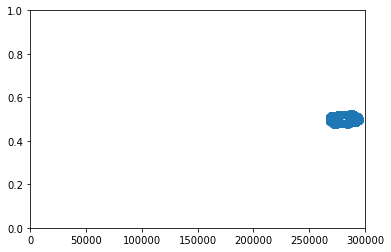

In [8]:
diag, winrates = generate_RPS_data(payoff_disc)
plt.scatter(diag, winrates)
plt.ylim(0, 1)
plt.xlim(0, 3e5)

In [9]:
data = np.concatenate([diag.reshape(-1, 1), winrates.reshape(-1, 1)], axis = 1)

In [10]:
savePickle(data, 'Disc Game RPS Data 1500')
savePickle(payoff_disc, 'Disc Game Payoff 1500')
savePickle(nash_clusters, 'Disc Game Nash Clusters 1500')

In [51]:
payoff = openPickle('Disc Game Payoff 1500')

In [57]:
pop_sizes = [1450]
training_performances = generate_training_data3(payoff, pop_sizes)

Population Size 1450
First Reached Peak at 50


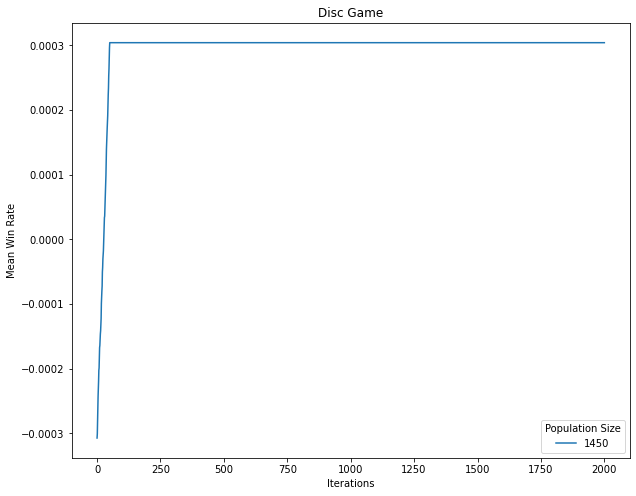

In [58]:
plot_training(training_performances, 'Disc Game')

In [35]:
savePickle(training_performances, 'Disc Game Training Uniform')

In [40]:
# With Nash
def compute_win_rate(curr_idx, payoff):
    return np.mean(payoff[curr_idx, :])

def compute_win_rate3(curr_strat_idx, payoff):
    # With Nash
    pop_size = len(curr_strat_idx)
    taken_idx = np.array(list(itertools.product(curr_strat_idx, repeat = 2)))
    taken_payoff = payoff[taken_idx[:, 0], taken_idx[:, 1]].reshape(pop_size, pop_size)
    p_vect, _ = solve_MaxEnt_NE(taken_payoff)
    prob_vect = np.zeros((payoff.shape[0]))
    prob_vect[curr_strat_idx] = p_vect
    return np.mean(prob_vect.reshape(1, -1) @ payoff)

def generate_training_data3(payoff, pop_sizes = [1, 25, 50, 75, 100, 150, 200, 250, 300, 350]):
    win_rates_results = dict()

    for pop_size in pop_sizes:
        print(f"Population Size {pop_size}")
        win_rates = []
        strat_strengths = np.mean(payoff > 0, axis = 1)
        ordering_idx = np.argsort(strat_strengths)

        curr_strat_idx = list(ordering_idx[:pop_size])
        if pop_size == 1:
            win_rates.append(compute_win_rate(curr_strat_idx, payoff))
        else:
            win_rates.append(compute_win_rate3(curr_strat_idx, payoff))
        n_iters = 2000; it = 0
        converge = False; prev_win_rate = 0
        while it < n_iters:
            taken_payoff = np.sum(payoff[:, curr_strat_idx], axis = 1)
            viable_strats = np.where(taken_payoff > 0)[0]
            not_in = ~np.isin(viable_strats, curr_strat_idx)
            viable_strats = viable_strats[not_in]
            if len(viable_strats) > 0:
                viable_strengths = strat_strengths[viable_strats]
                sorted_idx = np.argsort(viable_strengths)
                new_strat = viable_strats[sorted_idx[0]]
                curr_strat_idx.append(new_strat)
                curr_strat_idx = curr_strat_idx[1:]
            else:
                if converge == False:
                    converge = True
                    it_conv = it
                    print(f"First Reached Peak at {it_conv}")

            if pop_size == 1:
                win_rates.append(compute_win_rate(curr_strat_idx, payoff))
            else:
                if converge:
                    win_rates.append(prev_win_rate)
                else:
                    prev_win_rate = compute_win_rate3(curr_strat_idx, payoff)
                    win_rates.append(prev_win_rate)
                    
            it += 1

        if converge == False:
            print(f"Population size {pop_size} doesn't converge")
            
        win_rates_results[pop_size] = win_rates
    
    return win_rates_results

def solve_MaxEnt_NE(payoff, verbose = False, eps = 1e-5, zero_tol = 1e-6, iters = 500, cycle = 5):
    
    init_val = np.random.uniform(size = payoff.shape[0])
    init_val = init_val / np.sum(init_val)
    
    p = cp.Variable(payoff.shape[0], value = init_val)
    constraints = [payoff @ p <= 0, cp.sum(p) == 1, p >= 0]
    objective = cp.sum(cp.entr(p))
    prob = cp.Problem(cp.Maximize(objective), constraints)
    
    try:
      cycle_count = 0; done = False
      while cycle_count < cycle and done is False:
        prob.solve(verbose = verbose, solver = cp.MOSEK, warm_start = True)
        p_vect = p.value * (p.value > zero_tol)
        diff = payoff @ p_vect.reshape(-1, 1)
#         print(f"Cycle count {cycle_count}, diff = {np.sum(diff >= eps)}")
        done = True if np.sum(diff >= eps) == 0 else False
        cycle_count += 1
    except cp.SolverError:
      print("MOSEK FAILED?")
      try:
        # Try ECOS_BB first
        cycle_count = 0; done = False
        while cycle_count < cycle and done is False:
          prob.solve(verbose = verbose, max_iters = 1000, solver = cp.ECOS_BB, warm_start = True)
          p_vect = p.value * (p.value > zero_tol)
          diff = payoff @ p_vect.reshape(-1, 1)
#           print(f"Cycle count {cycle_count}, diff = {np.sum(diff >= eps)}")
          done = True if np.sum(diff >= eps) == 0 else False
          cycle_count += 1
      except cp.SolverError:
        print("ECOS_BB FAILED")
        cycle_count = 0; done = False
        while cycle_count < cycle and done is False:
          prob.solve(verbose = verbose, max_iters = iters, solver = cp.SCS, warm_start = True)
          p_vect = p.value * (p.value > zero_tol)
          diff = payoff @ p_vect.reshape(-1, 1)
#           print(f"Cycle count {cycle_count}, diff = {np.sum(diff >= eps)}")
          done = True if np.sum(diff >= eps) == 0 else False
          cycle_count += 1
  
    # Clean - small values
    p_vect = p_vect * (p_vect > zero_tol)
    return p_vect, np.sum(diff>=eps)

In [42]:
pop_sizes = [1, 25, 50, 75, 100, 150, 200, 250, 300]
training_performances_nash = generate_training_data3(payoff, pop_sizes)

Population Size 1
Population size 1 doesn't converge
Population Size 25
Population size 25 doesn't converge
Population Size 50
Population size 50 doesn't converge
Population Size 75
Population size 75 doesn't converge
Population Size 100
Population size 100 doesn't converge
Population Size 150
Population size 150 doesn't converge
Population Size 200
Population size 200 doesn't converge
Population Size 250
Population size 250 doesn't converge
Population Size 300
Population size 300 doesn't converge


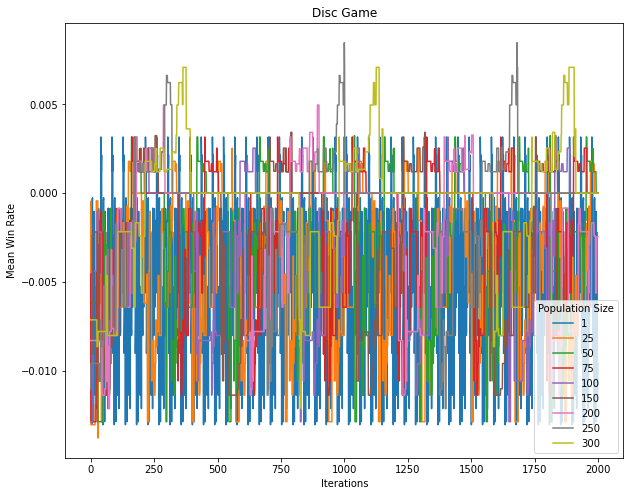

In [43]:
plot_training(training_performances_nash, 'Disc Game')

In [44]:
savePickle(training_performances_nash, 'Disc Game Training Nash')

In [72]:
# def compute_win_rate3(curr_strat_idx, payoff, verbose = False):
#     payoff_sieve = payoff[curr_strat_idx, :]
    
#     init = np.random.uniform(size = (len(curr_strat_idx)))
#     init = init / np.sum(init)
    
#     p = cp.Variable(len(curr_strat_idx), value = init )
#     uniform = np.ones(payoff_sieve.shape[1])
#     uniform = uniform / np.sum(uniform)
    
#     constraints = [cp.sum(p) == 1, p >= 0]
#     objective = cp.reshape(p, (1, len(curr_strat_idx))) @ payoff_sieve @ uniform.reshape(-1, 1)
#     prob = cp.Problem(cp.Maximize(objective), constraints)
    
#     prob.solve(verbose = verbose, solver = cp.MOSEK)
    
#     pvect = np.array(p.value)
    
#     return (pvect.reshape(1, -1) @ payoff_sieve @ uniform.reshape(-1, 1)).item()
#     return pvect

def compute_win_rate3(curr_strat_idx, payoff):
    # With Nash
    pop_size = len(curr_strat_idx)
    taken_idx = np.array(list(itertools.product(curr_strat_idx, repeat = 2)))
    taken_payoff = payoff[taken_idx[:, 0], taken_idx[:, 1]].reshape(pop_size, pop_size)
    p_vect, _ = solve_MaxEnt_NE(taken_payoff)
    prob_vect = np.zeros((payoff.shape[0]))
    prob_vect[curr_strat_idx] = p_vect
    return np.mean(prob_vect.reshape(1, -1) @ payoff)

In [73]:
res = compute_win_rate3(np.arange(1500), payoff)

In [74]:
res

-7.571168460353539e-16

### Elo Game

In [27]:
def create_payoff_elo(bin_lb, bin_ub, n):
    bins = np.array(create_bins(bin_lb, bin_ub, n))
    payoff = np.ones((n, n)) * -8; np.fill_diagonal(payoff, 0)
    
    for i in tqdm(range(len(bins))):
        for j in range(len(bins)):
            p1_bin_lb, p1_bin_ub = bins[i]
            p2_bin_lb, p2_bin_ub = bins[j]
            
            # Mid-bin rating to predict if missing
            p1_rating = (p1_bin_ub + p1_bin_lb) / 2
            p2_rating = (p2_bin_ub + p2_bin_lb) / 2
            
            if p1_bin_lb >= p2_bin_lb:
                continue
            else:
                win_prob = win_rate_elo(p1_rating, p2_rating)
                value = win_prob * 1 + (1 - win_prob) * (-1)
                payoff[i,j] = value
                payoff[j,i] = -value
                
    return payoff

In [28]:
payoff = create_payoff_elo(750, 2950, 1500)
markers = np.zeros((1500, 1500))

100%|██████████| 1500/1500 [00:07<00:00, 206.95it/s]


In [30]:
nash_clusters, _, _ = Nash_Clustering(payoff, markers)

Iteration 0
Cycle count 0, diff = 0
Outside, diff = 0
Strategies left 1499
Payoff remaining size 1499
Iteration 1
Cycle count 0, diff = 0
Outside, diff = 0
Strategies left 1498
Payoff remaining size 1498
Iteration 2
Cycle count 0, diff = 0
Outside, diff = 0
Strategies left 1497
Payoff remaining size 1497
Iteration 3
Cycle count 0, diff = 0
Outside, diff = 0
Strategies left 1496
Payoff remaining size 1496
Iteration 4
Cycle count 0, diff = 0
Outside, diff = 0
Strategies left 1495
Payoff remaining size 1495
Iteration 5
Cycle count 0, diff = 0
Outside, diff = 0
Strategies left 1494
Payoff remaining size 1494
Iteration 6
Cycle count 0, diff = 0
Outside, diff = 0
Strategies left 1493
Payoff remaining size 1493
Iteration 7
Cycle count 0, diff = 0
Outside, diff = 0
Strategies left 1492
Payoff remaining size 1492
Iteration 8
Cycle count 0, diff = 0
Outside, diff = 0
Strategies left 1491
Payoff remaining size 1491
Iteration 9
Cycle count 0, diff = 0
Outside, diff = 0
Strategies left 1490
Payoff 

KeyboardInterrupt: 

In [ ]:
adj, winrates = generate_RPS_data(payoff)
data_rps = np.concatenate([adj.reshape(-1, 1), winrates.reshape(-1, 1)], axis = 1)

In [ ]:
savePickle(payoff, "Elo Game Payoff 1500")
savePickle(nash_clusters, "Elo Game Nash Clusters 1500")
x = np.array([nc.size for nc in nash_clusters])
y = np.linspace(0, 1, len(nash_clusters))
data = np.concatenate([x.reshape(-1, 1), y.reshape(-1, 1)], axis = 1)
savePickle(data, 'Elo Game NC Data 1500')
savePickle(data_rps, 'Elo Game RPS Data 1500')

In [47]:
payoff = openPickle('Elo Game Payoff 1500')

In [37]:
pop_sizes = [1, 25, 50, 75, 100, 150, 200, 250, 300]
training_performances = generate_training_data(payoff, pop_sizes)

Population Size 1
First Reached Peak at 1499
Population Size 25
First Reached Peak at 1475
Population Size 50
First Reached Peak at 1450
Population Size 75
First Reached Peak at 1425
Population Size 100
First Reached Peak at 1400
Population Size 150
First Reached Peak at 1350
Population Size 200
First Reached Peak at 1300
Population Size 250
First Reached Peak at 1250
Population Size 300
First Reached Peak at 1200


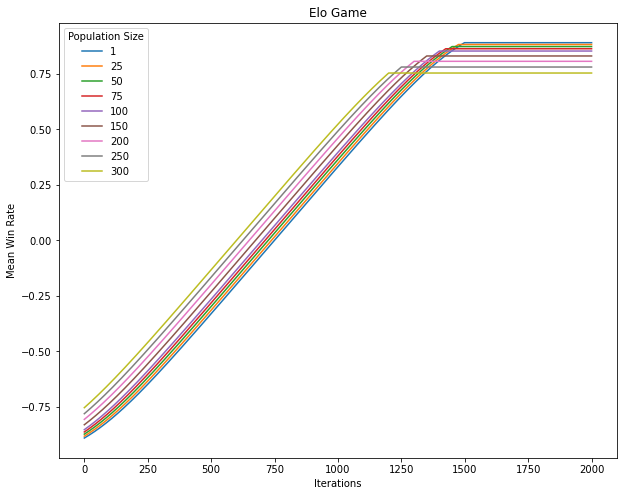

In [38]:
plot_training(training_performances, 'Elo Game')

In [39]:
savePickle(training_performances, 'Elo Game Training Uniform')

In [48]:
pop_sizes = [1, 25, 50, 75, 100, 150, 200, 250, 300]
training_performances_nash = generate_training_data3(payoff, pop_sizes)

Population Size 1
First Reached Peak at 1499
Population Size 25
First Reached Peak at 1475
Population Size 50
First Reached Peak at 1450
Population Size 75
First Reached Peak at 1425
Population Size 100
First Reached Peak at 1400
Population Size 150
First Reached Peak at 1350
Population Size 200
First Reached Peak at 1300
Population Size 250
First Reached Peak at 1250
Population Size 300
First Reached Peak at 1200


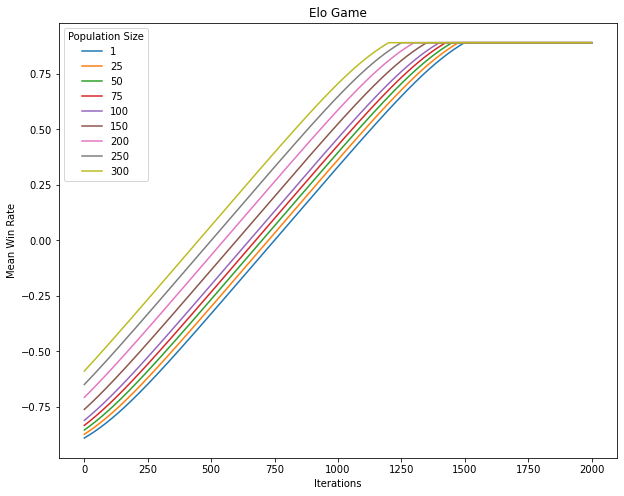

In [49]:
plot_training(training_performances_nash, 'Elo Game')

In [50]:
savePickle(training_performances_nash, 'Elo Game Training Nash')